In [5]:
%load_ext autoreload
%autoreload 2

# Get parent directory and add to sys.path
import os
import sys

parent_dir = os.path.dirname(os.getcwd())
sys.path.append(parent_dir)

# Require ipympl
%matplotlib widget 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
# MPC import
from MPCVelControl_D4_1 import MPCVelControl
from PIControl.PIControl import PIControl
import numpy as np
from src.rocket import Rocket
from src.vel_rocket_vis import RocketVis

rocket_obj_path = os.path.join(parent_dir, "Cartoon_rocket.obj")
rocket_params_path = os.path.join(parent_dir, "rocket.yaml")

In [7]:
Ts = 0.05
sim_time = 20
H = 5.0
x0 = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 50, 50, 100])  # initial state
pos_target = np.array([0, 0, 10.0])

rocket = Rocket(Ts=Ts, model_params_filepath=rocket_params_path)
pos_controller = PIControl(pos_target)
mpc = MPCVelControl().new_controller(rocket, Ts, H)

t_cl, x_cl, u_cl, t_ol, x_ol, u_ol, ref = rocket.simulate_control(
    mpc, sim_time, H, x0, pos_control=pos_controller, method="nonlinear"
)

vis = RocketVis(rocket, rocket_obj_path)
vis.anim_rate = 1.0
vis.animate(
    t_cl[:-1],
    x_cl[:, :-1],
    u_cl,
    Ref=ref[:, :-1],
    T_ol=t_ol[..., :-1],
    X_ol=x_ol,
    U_ol=u_ol,
);

Maximum invariant set successfully computed after 11 iterations.
Maximum invariant set successfully computed after 11 iterations.
Maximum invariant set successfully computed after 1 iterations.
Maximum invariant set successfully computed after 18 iterations.
Simulating time 0.00: 
Simulating time 0.05: max predicted state violation with du=0: 2.3716252220516516
worst viol = 2.372 at state i=1 (global idx 4), step k=100
dx_pred[i,k] = -2.5451581472510845 bounds: -0.17353292519943295 0.17353292519943295
subsystem: MPCControl_xvel_tuned_final
x_ids: [1 4 6] u_ids: [1]
max predicted state violation with du=0: 2.2855595263483006
worst viol = 2.286 at state i=1 (global idx 3), step k=100
dx_pred[i,k] = 2.4590924515477335 bounds: -0.17353292519943295 0.17353292519943295
subsystem: MPCControl_yvel_tuned_final
x_ids: [0 3 7] u_ids: [0]

Simulating time 0.10: max predicted state violation with du=0: 4.942026839228443
worst viol = 4.942 at state i=1 (global idx 4), step k=100
dx_pred[i,k] = -5.11

AppLayout(children=(HBox(children=(Play(value=0, description='Press play', max=399, step=2), IntSlider(value=0…

Maximum invariant set successfully computed after 10 iterations.
Maximum invariant set successfully computed after 10 iterations.
Maximum invariant set successfully computed after 1 iterations.
Simulating time 0.00: 
Simulating time 0.05: max predicted state violation with du=0: 4.257944651826761
worst viol = 4.258 at state i=1 (global idx 4), step k=100
dx_pred[i,k] = 4.431477577026194 bounds: -0.17353292519943295 0.17353292519943295
subsystem: MPCControl_xvel
x_ids: [1 4 6] u_ids: [1]
max predicted state violation with du=0: 4.109150148961868
worst viol = 4.109 at state i=1 (global idx 3), step k=100
dx_pred[i,k] = -4.282683074161302 bounds: -0.17353292519943295 0.17353292519943295
subsystem: MPCControl_yvel
x_ids: [0 3 7] u_ids: [0]

 State z violation: -0.00 < 0.00, 
Simulating time 0.10: max predicted state violation with du=0: 8.643980915146727
worst viol = 8.644 at state i=1 (global idx 4), step k=100
dx_pred[i,k] = 8.81751384034616 bounds: -0.17353292519943295 0.173532925199432

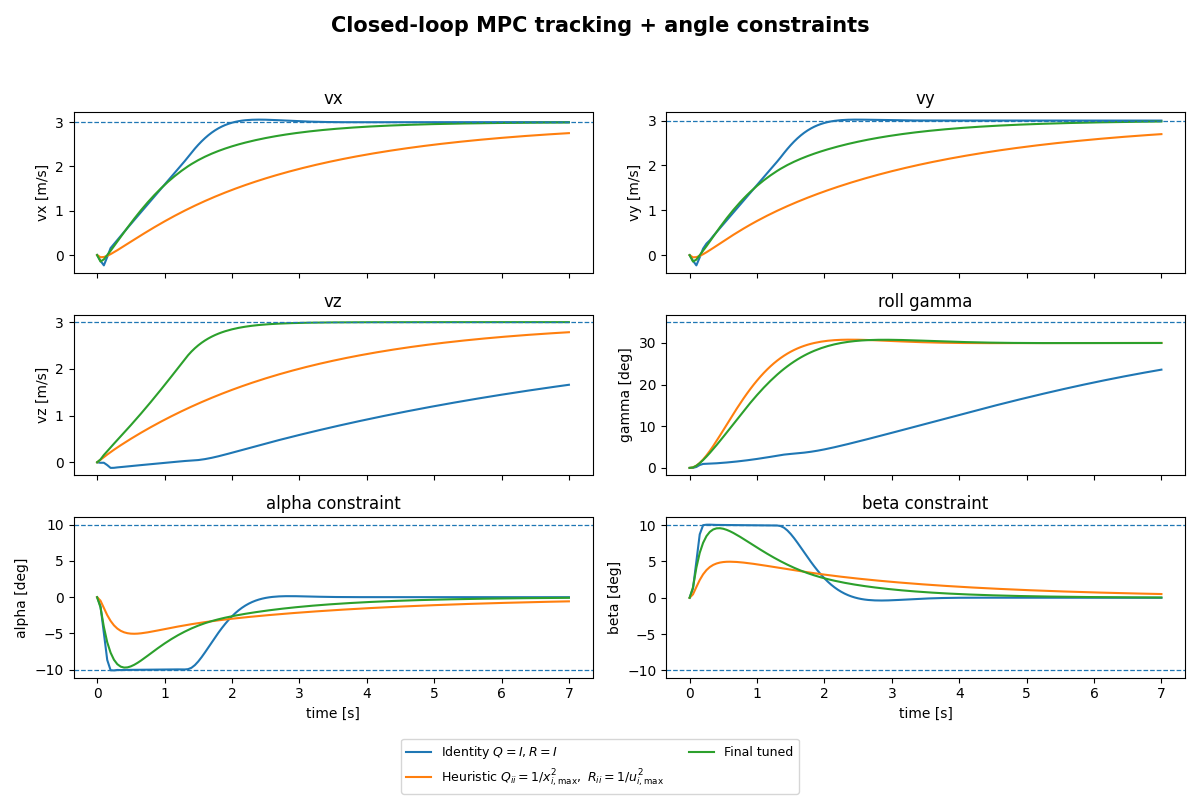

In [8]:
import numpy as np
import matplotlib.pyplot as plt

Ts = 0.05
sim_time = 7
H = 5.0

rocket = Rocket(Ts=Ts, model_params_filepath=rocket_params_path)
xs, us = rocket.trim()
x0 = xs.copy()

x_ref = xs.copy()
x_ref[6] = 3.0
x_ref[7] = 3.0
x_ref[8] = 3.0
x_ref[5] = np.deg2rad(30.0)

# 1) Import the base MPCVelControl class (the one that has get_u etc.)
from MPCVelControl_D4_1 import MPCVelControl

# 2) Import the MPC subsystem controller classes
from MPCControl_xvel_D4_1 import MPCControl_xvel, MPCControl_xvel_tuned_default, MPCControl_xvel_tuned_final
from MPCControl_yvel_D4_1 import MPCControl_yvel, MPCControl_yvel_tuned_default, MPCControl_yvel_tuned_final
from MPCControl_zvel_D4_1 import MPCControl_zvel, MPCControl_zvel_tuned_default, MPCControl_zvel_tuned_final
from MPCControl_roll_D4_1 import MPCControl_roll, MPCControl_roll_tuned_default, MPCControl_roll_tuned_final

# 3) Define the 3 variants
class MPCVelControl_I(MPCVelControl):
    def new_controller(self, rocket, Ts, H):
        self.xs, self.us = rocket.trim()
        A, B = rocket.linearize(self.xs, self.us)
        self.mpc_x    = MPCControl_xvel(A, B, self.xs, self.us, Ts, H)
        self.mpc_y    = MPCControl_yvel(A, B, self.xs, self.us, Ts, H)
        self.mpc_z    = MPCControl_zvel(A, B, self.xs, self.us, Ts, H)
        self.mpc_roll = MPCControl_roll(A, B, self.xs, self.us, Ts, H)
        return self

class MPCVelControl_TD(MPCVelControl):
    def new_controller(self, rocket, Ts, H):
        self.xs, self.us = rocket.trim()
        A, B = rocket.linearize(self.xs, self.us)
        self.mpc_x    = MPCControl_xvel_tuned_default(A, B, self.xs, self.us, Ts, H)
        self.mpc_y    = MPCControl_yvel_tuned_default(A, B, self.xs, self.us, Ts, H)
        self.mpc_z    = MPCControl_zvel_tuned_default(A, B, self.xs, self.us, Ts, H)
        self.mpc_roll = MPCControl_roll_tuned_default(A, B, self.xs, self.us, Ts, H)
        return self

class MPCVelControl_TF(MPCVelControl):
    def new_controller(self, rocket, Ts, H):
        self.xs, self.us = rocket.trim()
        A, B = rocket.linearize(self.xs, self.us)
        self.mpc_x    = MPCControl_xvel_tuned_final(A, B, self.xs, self.us, Ts, H)
        self.mpc_y    = MPCControl_yvel_tuned_final(A, B, self.xs, self.us, Ts, H)
        self.mpc_z    = MPCControl_zvel_tuned_final(A, B, self.xs, self.us, Ts, H)
        self.mpc_roll = MPCControl_roll_tuned_final(A, B, self.xs, self.us, Ts, H)
        return self


# --- controller sets (yours) ---
ctrl_sets_cl = {
    "Identity $Q=I,R=I$": MPCVelControl_I,
    r"Heuristic $Q_{ii}=1/x_{i,\max}^2,\ R_{ii}=1/u_{i,\max}^2$": MPCVelControl_TD,
    "Final tuned": MPCVelControl_TF,
}

def run_closed_loop(mpc_full_cls, method):
    mpc = mpc_full_cls().new_controller(rocket, Ts, H)
    t_cl, x_cl, u_cl, *_ = rocket.simulate_control(
        mpc, sim_time, H, x0, method=method, x_target=x_ref
    )
    return t_cl, x_cl, u_cl

# -----------------------------
# Run each controller ONCE
# -----------------------------
results = {}
for lbl, mpc_cls in ctrl_sets_cl.items():
    # pick one:
    # method = "linear"
    method = "nonlinear"
    results[lbl] = run_closed_loop(mpc_cls, method=method)

# -----------------------------
# Plot tracking + angles (3x2)
# -----------------------------
fig, axs = plt.subplots(3, 2, figsize=(12, 8), sharex=True)
fig.suptitle("Closed-loop MPC tracking + angle constraints", fontsize=15, fontweight="bold")

def hline(ax, y):
    ax.axhline(y, linestyle="--", linewidth=0.9)

# vx
ax = axs[0,0]
for lbl,(t,x,u) in results.items():
    ax.plot(t, x[6,:], label=lbl)
hline(ax, 3.0)
ax.set_ylabel("vx [m/s]")
ax.set_title("vx")

# vy
ax = axs[0,1]
for lbl,(t,x,u) in results.items():
    ax.plot(t, x[7,:], label=lbl)
hline(ax, 3.0)
ax.set_ylabel("vy [m/s]")
ax.set_title("vy")

# vz
ax = axs[1,0]
for lbl,(t,x,u) in results.items():
    ax.plot(t, x[8,:], label=lbl)
hline(ax, 3.0)
ax.set_ylabel("vz [m/s]")
ax.set_title("vz")

# gamma
ax = axs[1,1]
for lbl,(t,x,u) in results.items():
    ax.plot(t, np.rad2deg(x[5,:]), label=lbl)
hline(ax, 35.0)
ax.set_ylabel("gamma [deg]")
ax.set_title("roll gamma")

# alpha (idx 3) with ±10°
ax = axs[2,0]
for lbl,(t,x,u) in results.items():
    ax.plot(t, np.rad2deg(x[3,:]), label=lbl)
hline(ax, 10.0); hline(ax, -10.0)
ax.set_ylabel("alpha [deg]")
ax.set_title("alpha constraint")

# beta (idx 4) with ±10°
ax = axs[2,1]
for lbl,(t,x,u) in results.items():
    ax.plot(t, np.rad2deg(x[4,:]), label=lbl)
hline(ax, 10.0); hline(ax, -10.0)
ax.set_ylabel("beta [deg]")
ax.set_title("beta constraint")

for ax in axs[-1,:]:
    ax.set_xlabel("time [s]")

handles, labels = axs[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", ncol=2, fontsize=9, frameon=True)
plt.tight_layout(rect=[0, 0.08, 1, 0.95])
plt.show()


In [ ]:
#mini change test